In [1]:
# TODO Required modules
!pip install torch
!pip install numpy
!pip install pandas
!pip install kagglehub
!pip install pyswarms
!pip install mealpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import pyswarms as ps
from mealpy.swarm_based.WOA import OriginalWOA
from mealpy.utils.problem import Problem
from mealpy.utils.space import IntegerVar

# data processing

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xandywang","key":"e9db2e9f7c8bccdd449e3163ac82077c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()  # 如果 kaggle.json 在当前目录


In [5]:
!kaggle datasets download -d prasoonkottarathil/btcinusd


Dataset URL: https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd
License(s): CC-BY-SA-4.0


In [6]:
!unzip btcinusd.zip

import pandas as pd
df = pd.read_csv("BTC-Daily.csv")
df.head()


Archive:  btcinusd.zip
  inflating: BTC-2017min.csv         
  inflating: BTC-2018min.csv         
  inflating: BTC-2019min.csv         
  inflating: BTC-2020min.csv         
  inflating: BTC-2021min.csv         
  inflating: BTC-Daily.csv           
  inflating: BTC-Hourly.csv          


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [7]:
def preprocess_data(path, fileName):
    file_path = f"{path}/{fileName}"
    data = pd.read_csv(file_path)
    dates = data['date'].tolist()
    prices = data['close'].tolist()
    df = pd.DataFrame({'date': dates, 'price': prices}).sort_values('date').reset_index(drop=True)
    return df

fileName = "BTC-Daily.csv"
train_df = preprocess_data('.', fileName)
cutoff = 0.3
test_size = int(len(train_df) * cutoff)
train_prices, test_prices = train_df['price'][:-test_size], train_df['price'][-test_size:]

# New Section

SMA and simulated trading functions

In [8]:
def pad(series, n):
    return np.append(np.flip(series[1:n]), series)

def sma_filter(series, n):
    padded = pad(series, n)
    return pd.Series(padded).rolling(window=n).mean().to_numpy()[n - 1:]

def simulate_trading(x, prices, initial_capital=1000, fee_rate=0.03):
    sma1, sma2 = int(round(x[0])), int(round(x[1]))
    if sma1 >= sma2:
        return 1e9  # 不合法

    sma_short, sma_long = sma_filter(prices, sma1), sma_filter(prices, sma2)
    state = np.where(sma_short > sma_long, 1, -1)
    signal = np.diff(state)

    capital, shares = initial_capital, 0
    for i in range(max(sma1, sma2), len(prices)):
        if signal[i - 1] == 2:  # 买
            shares = capital * (1 - fee_rate) / prices.iloc[i]
            capital = 0
        elif signal[i - 1] == -2 and shares > 0:  # 卖
            capital = shares * prices.iloc[i] * (1 - fee_rate)
            shares = 0
    # 结束强制平仓
    if shares > 0:
        capital = shares * prices.iloc[-1] * (1 - fee_rate)
    return -capital  # 优化最小化

Algorithm

In [40]:
# --------------------------- Firefly Algorithm ---------------------------

class FireflyAlgorithm:
    def __init__(self, pop_size=25, alpha=0.8, betamin=0.2, gamma=1.0, seed=None):
        self.pop_size, self.alpha, self.betamin, self.gamma = pop_size, alpha, betamin, gamma
        self.rng = default_rng(seed)


    def run(self, fitness_fn, dim, lb, ub, max_evals=500):
        fireflies = self.rng.uniform(lb, ub, (self.pop_size, dim))
        intensity = np.apply_along_axis(fitness_fn, 1, fireflies)
        evals = self.pop_size
        while evals < max_evals:
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if intensity[i] >= intensity[j]:
                        r = np.sum((fireflies[i] - fireflies[j]) ** 2)
                        beta = self.betamin * np.exp(-self.gamma * r)
                        step = self.alpha * (self.rng.random(dim) - 0.5) * (ub - lb)
                        fireflies[i] += beta * (fireflies[j] - fireflies[i]) + step
                        fireflies[i] = np.clip(fireflies[i], lb, ub)
                        intensity[i] = fitness_fn(fireflies[i])
                        evals += 1
        best_idx = np.argmin(intensity)
        return intensity[best_idx], fireflies[best_idx]

# --------------------------- PSO Algorithm (类封装) ---------------------------

class PSOAlgorithm:
    def __init__(self, particles=25, iters=50, c1=0.5, c2=0.2, w=0.9, seed=None):
        self.particles, self.iters, self.c1, self.c2, self.w = particles, iters, c1, c2, w
        self.seed = seed

    def run(self, fitness_fn, dim, lb, ub):
        np.random.seed(self.seed)
        options = {"c1": self.c1, "c2": self.c2, "w": self.w}
        optimizer = ps.single.GlobalBestPSO(n_particles=self.particles, dimensions=dim,
                                            options=options, bounds=(lb, ub))
        best_cost, best_pos = optimizer.optimize(lambda x: np.apply_along_axis(fitness_fn, 1, x), iters=self.iters)
        return best_cost, best_pos

# --------------------------- WOA Algorithm (类封装) ---------------------------

class WOAAlgorithm:
    def __init__(self, epochs=50, pop_size=25, seed=None):
        self.epochs, self.pop_size, self.seed = epochs, pop_size, seed

    def run(self, fitness_fn, dim, lb, ub):
        np.random.seed(self.seed)
        bounds = [IntegerVar(int(lb[i]), int(ub[i])) for i in range(dim)]
        problem = Problem(obj_func=lambda sol: fitness_fn(np.array(sol)), bounds=bounds, minmax="min", verbose=False)
        optimizer = OriginalWOA(epoch=self.epochs, pop_size=self.pop_size)
        optimizer.solve(problem)
        return optimizer.g_best.target, optimizer.g_best.solution

Baseline strategy

In [10]:
def baseline_strategy(prices, sma_short=10, sma_long=30):
    return -simulate_trading([sma_short, sma_long], prices)

Multiple sub-statistics

In [11]:
def multi_seed_stats(algorithm_cls, algo_kwargs, seeds, lb, ub, run_kwargs=None):
    """运行算法多次，返回 (results_array, best_params_list)"""
    run_kwargs = run_kwargs or {}
    results, best_params_list = [], []
    for s in seeds:
        algo = algorithm_cls(seed=s, **algo_kwargs)
        cost, params = algo.run(lambda x: simulate_trading(x, train_prices), 2, lb, ub, **run_kwargs)
        results.append(-simulate_trading(params, test_prices))
        best_params_list.append(params)
    return np.array(results), best_params_list

Execute and count (average performance + record the best window)

In [43]:
lb, ub = np.array([5, 31]), np.array([30, 200])
seeds = range(10)

firefly_res, firefly_params = multi_seed_stats(
    FireflyAlgorithm,
    {"pop_size": 25, "alpha": 1.0, "betamin": 1.0, "gamma": 0.0},
    seeds, lb, ub,
    run_kwargs={"max_evals": 500}
)

baseline_score = -simulate_trading([10, 30], test_prices)
baseline_res = np.array([baseline_score] * len(seeds))

In [44]:
pso_res, pso_params = multi_seed_stats(PSOAlgorithm, {"particles": 25, "iters": 50}, seeds, lb, ub)

2025-05-06 08:17:45,393 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-5.1e+4
2025-05-06 08:17:47,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -50989.82733020279, best pos: [ 24.74710579 145.50273145]
2025-05-06 08:17:47,598 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-5.07e+4
2025-05-06 08:17:50,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -50717.21117097116, best pos: [ 26.4308348  152.55350259]
2025-05-06 08:17:50,438 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-5.1e+4
2025-05-06 08:17:52,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -50989.827

In [41]:
woa_res, woa_params = multi_seed_stats(
    WOAAlgorithm,
    {"epochs": 100, "pop_size": 25},
    seeds, lb, ub
)

2025-05-06 08:15:44,777 - mealpy.swarm_based.WOA.OriginalWOA - INFO - Solving single objective optimization problem.
2025-05-06 08:15:44,856 - mealpy.swarm_based.WOA.OriginalWOA - INFO - >>>Problem: P, Epoch: 1, Current best: -37052.04058509193, Global best: -37052.04058509193, Runtime: 0.03720 seconds
2025-05-06 08:15:44,895 - mealpy.swarm_based.WOA.OriginalWOA - INFO - >>>Problem: P, Epoch: 2, Current best: -40687.24036980644, Global best: -40687.24036980644, Runtime: 0.03771 seconds
2025-05-06 08:15:44,935 - mealpy.swarm_based.WOA.OriginalWOA - INFO - >>>Problem: P, Epoch: 3, Current best: -41676.88334898795, Global best: -41676.88334898795, Runtime: 0.03880 seconds
2025-05-06 08:15:44,975 - mealpy.swarm_based.WOA.OriginalWOA - INFO - >>>Problem: P, Epoch: 4, Current best: -41676.88334898795, Global best: -41676.88334898795, Runtime: 0.03802 seconds
2025-05-06 08:15:45,017 - mealpy.swarm_based.WOA.OriginalWOA - INFO - >>>Problem: P, Epoch: 5, Current best: -41676.88334898795, Global

Calculate the best window obtained by each algorithm when seed=0

In [45]:
algos = ["Firefly", "PSO", "WOA", "Baseline"]
all_res = [firefly_res, pso_res, woa_res, baseline_res]
means = [r.mean() for r in all_res]
stds  = [r.std()  for r in all_res]

print("--- Average return and standard deviation ---")
for name, m, sd in zip(algos, means, stds):
    print(f"{name:<8} average: {m:.2f}  Standard deviation: {sd:.2f}")

print("--- Best window (seed=0) ---")
print(f"Firefly: SMA1={int(firefly_params[0][0])}, SMA2={int(firefly_params[0][1])}")
print(f"PSO:     SMA1={int(pso_params[0][0])}, SMA2={int(pso_params[0][1])}")
print(f"WOA:     SMA1={int(woa_params[0][0])}, SMA2={int(woa_params[0][1])}")



--- Average return and standard deviation ---
Firefly  average: 931.00  Standard deviation: 23.52
PSO      average: 904.94  Standard deviation: 11.99
WOA      average: 866.74  Standard deviation: 59.43
Baseline average: 1956.06  Standard deviation: 0.00
--- Best window (seed=0) ---
Firefly: SMA1=26, SMA2=152
PSO:     SMA1=24, SMA2=145
WOA:     SMA1=24, SMA2=187


Visual comparison diagram

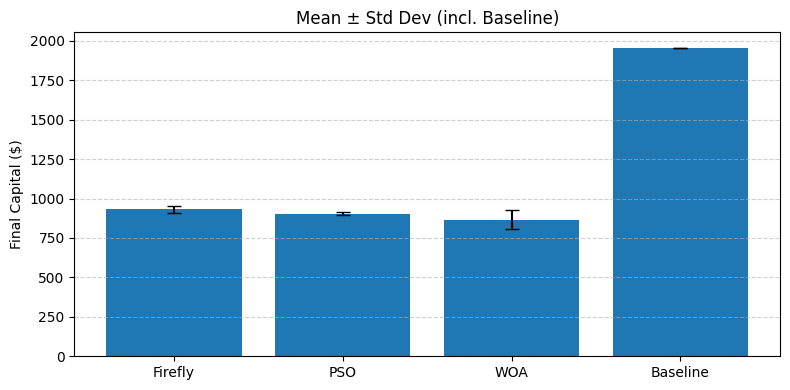

<ipython-input-46-a02fd9ffc464>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_res, labels=algos, showmeans=True)


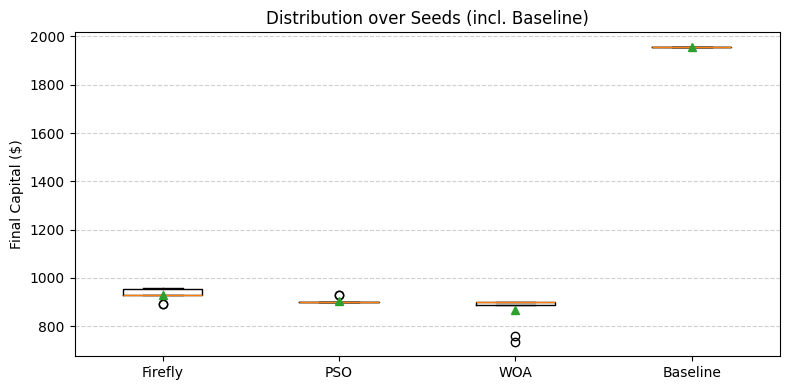

In [46]:
plt.figure(figsize=(8,4))
plt.bar(algos, means, yerr=stds, capsize=5)
plt.ylabel('Final Capital ($)')
plt.title('Mean ± Std Dev (incl. Baseline)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.boxplot(all_res, labels=algos, showmeans=True)
plt.ylabel('Final Capital ($)')
plt.title('Distribution over Seeds (incl. Baseline)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-47-8189b982042e>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(res, label=name, fill=True, alpha=0.2)


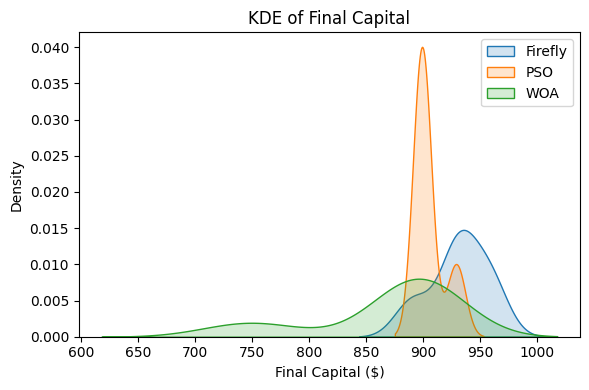

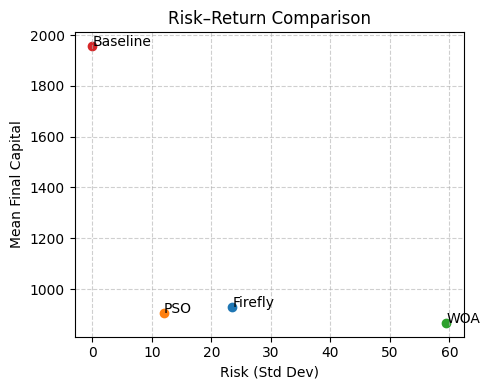

In [47]:
import seaborn as sns

# KDE
plt.figure(figsize=(6,4))
for res, name in zip(all_res, algos):
    sns.kdeplot(res, label=name, fill=True, alpha=0.2)
plt.title("KDE of Final Capital")
plt.xlabel("Final Capital ($)")
plt.legend(); plt.tight_layout(); plt.show()

# Risk–Return scatter
plt.figure(figsize=(5,4))
for m, sd, name in zip(means, stds, algos):
    plt.scatter(sd, m, label=name)
    plt.text(sd, m, name)
plt.xlabel("Risk (Std Dev)")
plt.ylabel("Mean Final Capital")
plt.title("Risk–Return Comparison")
plt.grid(True, ls="--", alpha=0.6)
plt.tight_layout(); plt.show()

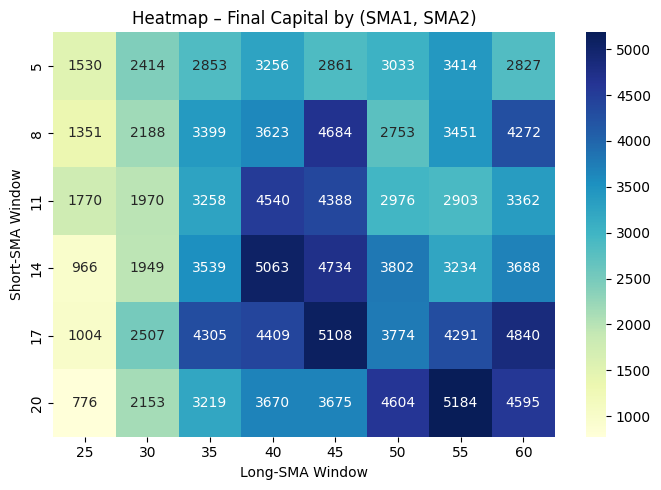

In [48]:
# ====  (Parameter Sensitivity) ====
short_range = range(5, 21, 3)      # 5,8,11,14,17,20
long_range  = range(25, 61, 5)     # 25,30,...,60
heat = np.zeros((len(short_range), len(long_range)))

for i, s in enumerate(short_range):
    for j, l in enumerate(long_range):
        if s >= l:
            heat[i,j] = np.nan      # 无效组合
        else:
            heat[i,j] = -simulate_trading([s,l], test_prices)   # 正收益

plt.figure(figsize=(7,5))
sns.heatmap(heat, annot=True, fmt=".0f", cmap="YlGnBu",
            xticklabels=list(long_range), yticklabels=list(short_range))
plt.xlabel("Long‑SMA Window"); plt.ylabel("Short‑SMA Window")
plt.title("Heatmap – Final Capital by (SMA1, SMA2)")
plt.tight_layout(); plt.show()
